# Respiratory Binary Classification Approach

### Imports & Setup

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm

DATA_DIR = "C://Users/Malik/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database"
SOUND_DIR = os.path.join(DATA_DIR, "audio_and_txt_files")

In [2]:
def parse_annotation_file(ann_path):
    df = pd.read_csv(ann_path, header=None, sep='\t',
                     names=['start', 'end', 'crackle', 'wheeze'])
    df['duration'] = df['end'] - df['start']
    return df

Extracting MEL Spectrograms per respiratory cycle; this attempt will use CNNs for classification.

In [3]:
def extract_mel_segment(audio_path, start, end, sr=22050, n_mels=128, fmax=8000):
    y, sr = librosa.load(audio_path, sr=sr)
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    segment = y[start_sample:end_sample]
    if len(segment) < sr * 2:  # pad short clips to 2 seconds
        segment = np.pad(segment, (0, int(sr*2) - len(segment)), mode='constant')
    mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to 128x128 for CNN input
    mel_db = librosa.util.fix_length(mel_db, size=128, axis=1)
    return mel_db

Now to build a dataset of MEL spectrograms labeled by presence/absence of wheeze/crackle sounds.

Processing files: 100%|██████████| 920/920 [01:16<00:00, 12.04it/s]


Dataset shape: (6898, 128, 128, 1), Labels: (6898,), Positive rate: 0.47


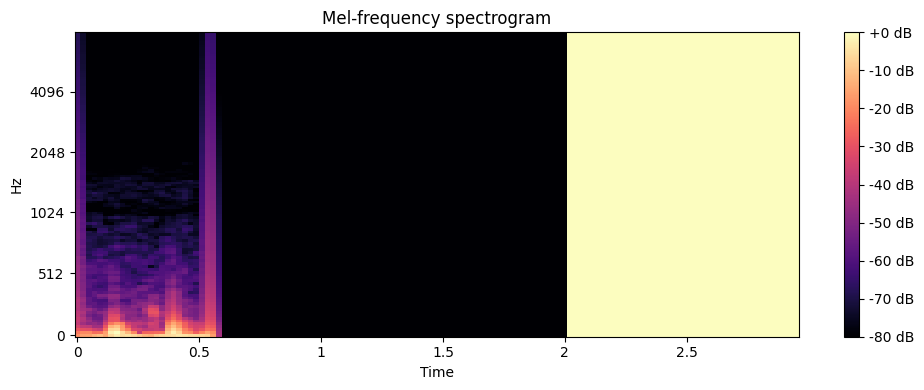

In [4]:
mel_features = []
labels = []

annotation_files = [f for f in os.listdir(SOUND_DIR) if f.endswith(".txt")]

for ann_file in tqdm(annotation_files, desc="Processing files"):
    base_name = ann_file.replace('.txt', '.wav')
    audio_path = os.path.join(SOUND_DIR, base_name)
    ann_path = os.path.join(SOUND_DIR, ann_file)

    if not os.path.exists(audio_path):
        continue

    ann_df = parse_annotation_file(ann_path)

    for _, row in ann_df.iterrows():
        label = 1 if (row['crackle'] == 1 or row['wheeze'] == 1) else 0
        mel = extract_mel_segment(audio_path, row['start'], row['end'])
        mel_features.append(mel)
        labels.append(label)

X = np.array(mel_features)
y = np.array(labels)

# Reshape for CNN input: (samples, height, width, channels)
X = X[..., np.newaxis]

print(f"Dataset shape: {X.shape}, Labels: {y.shape}, Positive rate: {np.mean(y):.2f}")

# Print image example
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[0, :, :, 0], sr=22050,
                            x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Time to build the model and train it, for now this is a simple CNN architecture. We might need to add dropouts and regularization later if we see overfitting.

In [6]:
input_shape = (128, 128, 1)

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Malik\anaconda3\envs\lungenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,521 (107.50 KB)

 Trainable params: 27,521 (107.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5219 - loss: 0.7678 - val_accuracy: 0.5054 - val_loss: 0.7164
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5387 - loss: 0.6962 - val_accuracy: 0.5616 - val_loss: 0.6830
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5411 - loss: 0.6881 - val_accuracy: 0.5670 - val_loss: 0.6815
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5528 - loss: 0.6833 - val_accuracy: 0.5417 - val_loss: 0.6869
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5507 - loss: 0.6824 - val_accuracy: 0.5562 - val_loss: 0.6861
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5449 - loss: 0.6837 - val_accuracy: 0.5598 - val_loss: 0.6843
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5552 - loss: 0.6819 - val_accuracy: 0.5525 - val_loss: 0.6833
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5586 - loss: 0.6816 - val_accu

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

      Normal       0.59      0.43      0.50       729
    Abnormal       0.51      0.67      0.58       651

    accuracy                           0.54      1380
   macro avg       0.55      0.55      0.54      1380
weighted avg       0.55      0.54      0.54      1380



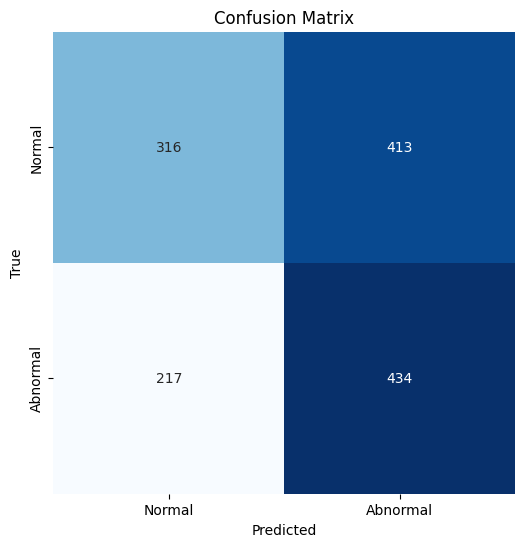

In [8]:
# Evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'], cbar=False, square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

It seems like the model just tries to vote normal for the most part. We need to check the class distribution.

In [9]:
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} samples")

Class Distribution:
Class 0: 3642 samples
Class 1: 3256 samples


Actually seems balanced enough. On the next version we can try normalization layer(s) and/or data augmentation.